In [237]:
#!pip install causalml econml
import numpy as np
from causalml.dataset import simulate_nuisance_and_easy_treatment
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from  econml.grf import CausalForest
from sklearn.model_selection import KFold
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_graph


# Causal Forest on simulated data

In [238]:
# Generate synthetic data for single simulation
np.random.seed(42)
y, X, treatment, tau, b, e = simulate_nuisance_and_easy_treatment(n=5000)

In [239]:
# Estimate a baseline RandomForest and a causal forest
base_model = DecisionTreeRegressor(random_state=42)
base_model.fit(y=y[:4000], # crime rate
              X=X[:4000] # features
             )

cf_model = CausalForest(random_state=42)
cf_model.fit(y=y[:4000], # crime rate
              T=treatment[:4000], # percent male
              X=X[:4000] # features
             )

predicted_base = base_model.predict(X[4000:])
predicted_cf = cf_model.predict_full(X[4000:])[:,1]

<AxesSubplot:>

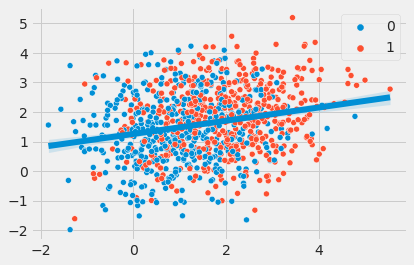

In [240]:
sns.regplot(x=y[4000:], y=predicted_base, scatter=False)
sns.scatterplot(x=y[4000:], y=predicted_base.flatten(), hue=treatment[4000:])

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 479.65it/s]


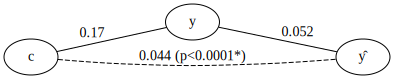

In [241]:
plot_graph(partial_confound_test(y=y[4000:], yhat=predicted_base.flatten(), c=treatment[4000:], cat_c=True))

<AxesSubplot:>

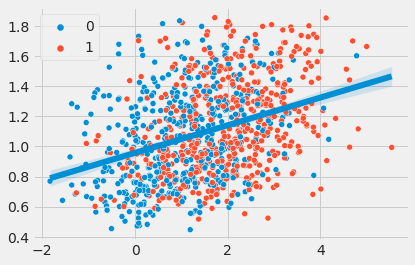

In [242]:
sns.regplot(x=y[4000:], y=predicted_cf, scatter=False)
sns.scatterplot(x=y[4000:], y=predicted_cf.flatten(), hue=treatment[4000:])

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 487.54it/s]


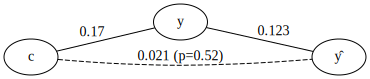

In [243]:
plot_graph(partial_confound_test(y=y[4000:], yhat=predicted_cf.flatten(), c=treatment[4000:], cat_c=True))

# Now we try it for the HCP dataset

In [185]:
# HCP data can be obtained from the connectomeDB with special license
# data is not part of this repository
subjectIDs = pd.read_csv('data/hcp/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('data/hcp/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('data/hcp/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('data/hcp/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80,23.5
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,28.0


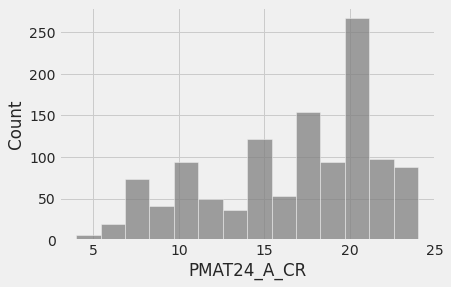

In [192]:
##########################################################
# change these
target = 'PMAT24_A_CR' # fluid intelligence
feature_data = netmats_parcor
##########################################################

sns.histplot(behavior[target], color='gray')
plt.savefig('../fig/raw/emp_hcp_iq_nonnorm_hist.pdf')

# it's a good practice to use pandas for merging, messing up subject order can be painful
features = feature_data.columns
df = behavior
df = df.merge(feature_data, left_index=True, right_index=True, how='left')
df = df.dropna(subset = [target] + features.values.tolist())
y = df[target].values
X = df[features].values

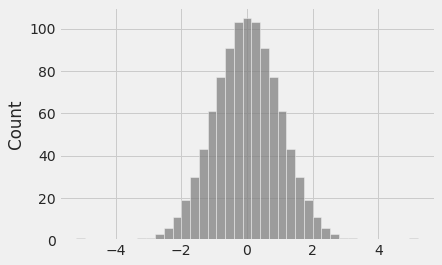

In [194]:
rng = np.random.default_rng(42)
y_trf = quantile_transform(np.array([y+rng.uniform(0,1,len(y))-0.5]).T, output_distribution='normal', n_quantiles=1000).flatten()

sns.histplot(y_trf, color='gray')
plt.savefig('../fig/raw/emp_hcp_iq_quanttrf_hist.pdf')

y=y_trf

In [206]:
model = CausalForest()


# nested cv
outer_cv = KFold(10)
predicted = np.zeros(len(y))

for train, test in outer_cv.split(X, y):

    model.fit(X=X[train], y=y[train], T=df.Acquisition.astype("category").cat.codes.values[train])
    predicted[test] = model.predict_full(X[test])[:,1].flatten()

*** Score on mean as model:	-1.0401469064852684
Explained Variance: -0.02256130734386952
Correlation: 0.11095172746707184


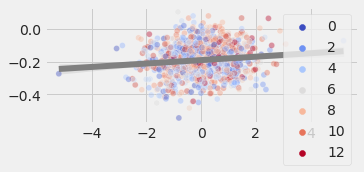

In [207]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("Explained Variance: " +  str( 1- -mean_squared_error(predicted, y)/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plt.figure(figsize=(5,2))
sns.regplot(x=y, y=predicted, scatter=False, color='gray')
sns.scatterplot(x=y, y=predicted, hue=df.Acquisition.astype("category").cat.codes.values,
                palette=sns.color_palette("coolwarm", as_cmap=True), alpha=0.4)
plt.savefig('../fig/raw/emp_hcp_acq_raw_regplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 448.74it/s]


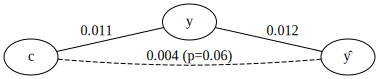

In [208]:
plot_graph(partial_confound_test(y, predicted, df.Acquisition.astype("category").cat.codes.values,
                                     random_state=42))